# LSTM을 이용한 로이터 뉴스 카테고리 분류
LSTM : 반복하기 직전에 다음 층으로 기억된 값을 넘길지 여부를 관리하는 단계를 하나 더 추가하는 것 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 불러온 데이터를 학습셋과 데이터셋으로 나누기
# reuters.load_data() : 기사불러오기 
# num_words : 빈도 높은 단어만 불러와 사용(1~1000에 해당하는 단어만 선택해서 불러오는 것)
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인한 후 출력
# np.max() : y_train의 종류 구하기(0부터 세기 때문에 1을 더해서 출력)
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
# 딥러닝은 단어를 그대로 사용하지 않고 숫자로 변환한 후 학습
print(X_train[0])

2121728/2110848 [==============================] - 0s 0us/step
46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [2]:
# maxlen=100 : 단어 수를 100개로 맞추라는 의미
# 100보다 크면 100개째 단어만 선택하고 나머지는 버림
# 100에서 모자랄 때는 모자라는 부분 모두 0으로 채움
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조 설정
# Embedding 층 : 데이터 전처리 과정을 통해 입력된 값을 받아 다음 층이 알 수 있는 형태로 변환하는 역할
#                (불러온 단어의 총 수, 기사당 단어 수) 형식으로 사용, 모델 설정 부분의 맨 처음에 있어야 함 
# LSTM : RNN에서 기억 값에 대한 가중치를 제어
#        (기사당 단어 수, 기타 옵션) 형식으로 사용, 활성화 함수로 주로 tanh 사용
# tanh : 실수 값을 (-1, 1) 범위로 압축하는 활성화 함수
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test),
                    callbacks=[early_stopping_callback])

# 테스트 정확도 출력 
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 27s 55ms/step - loss: 2.2331 - accuracy: 0.4417 - val_loss: 1.9974 - val_accuracy: 0.5151
Epoch 2/200
450/450 [==============================] - 23s 51ms/step - loss: 1.8308 - accuracy: 0.5289 - val_loss: 2.0492 - val_accuracy: 0.4506
Epoch 3/200
450/450 [==============================] - 24s 53ms/step - loss: 1.6449 - accuracy: 0.5796 - val_loss: 1.5997 - val_accuracy: 0.5886
Epoch 4/200
450/450 [==============================] - 24s 52ms/step - loss: 1.4384 - accuracy: 0.6339 - val_loss: 1.4600 - val_accuracy: 0.6358
Epoch 5/200
450/450 [==============================] - 24s 53ms/step - loss: 1.2591 - accuracy: 0.6836 - val_loss: 1.3237 - val_accuracy: 0.6670
Epoch 6/200
450/450 [==============================] - 23s 50ms/step - loss: 1.1486 - accuracy: 0.7081 - val_loss: 1.2398 - val_accuracy: 0.6799
Epoch 7/200
450/450 [==============================] - 23s 51ms/step - loss: 1.0542 - accuracy: 0.7312 - val_loss: 1.2115 - val_ac

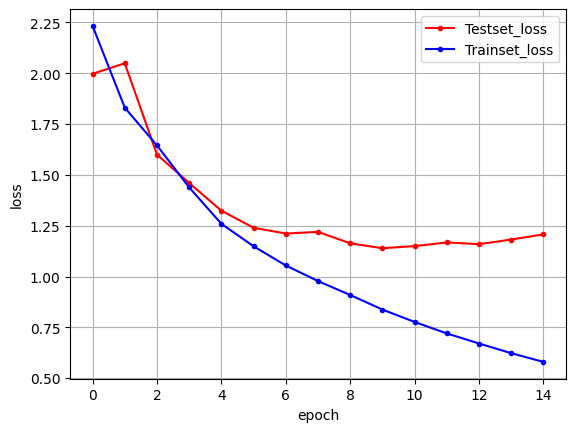

In [4]:
# 검증셋과 학습셋의 오차를 저장 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# LSTM과 CNN의 조합을 이용한 영화 리뷰 분류

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 학습셋, 테스트셋 지정
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수 맞추기
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델 구조 설정
# Conv1D : Conv2D의 개념을 1차원으로 옮긴 것 
#          컨볼루션 층이 1차원이고 이동하는 배열도 1차원
# MaxPooling1D : 2차원 배열을 1차원으로 바꾸어 정해진 구역 안에서 가장 큰 값을 다음 층으로 넘기고 나머지는 버림
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17473536/17464789 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 56        
_______________________________________________________

In [6]:
# 모델 실행 옵션 정하기 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델 실행
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 50s 103ms/step - loss: 0.4029 - accuracy: 0.8029 - val_loss: 0.2810 - val_accuracy: 0.8811
Epoch 2/100
469/469 [==============================] - 46s 99ms/step - loss: 0.2376 - accuracy: 0.9085 - val_loss: 0.2559 - val_accuracy: 0.8931
Epoch 3/100
469/469 [==============================] - 48s 103ms/step - loss: 0.1819 - accuracy: 0.9313 - val_loss: 0.2755 - val_accuracy: 0.8838
Epoch 4/100
469/469 [==============================] - 48s 103ms/step - loss: 0.1531 - accuracy: 0.9434 - val_loss: 0.3065 - val_accuracy: 0.8867
Epoch 5/100
782/782 [==============================] - 17s 22ms/step - loss: 0.3238 - accuracy: 0.8782

 Test Accuracy: 0.8782


# 어텐션을 사용한 신경망
어텐션 : 알파폴드의 중요한 축을 담당

In [4]:
!pip install attention

Epoch 1/100
625/625 [==============================] - 841s 1s/step - loss: 0.3833 - accuracy: 0.8230 - val_loss: 0.3036 - val_accuracy: 0.8724
Epoch 2/100
625/625 [==============================] - 581s 931ms/step - loss: 0.2260 - accuracy: 0.9106 - val_loss: 0.3183 - val_accuracy: 0.8581
Epoch 3/100
625/625 [==============================] - 307s 491ms/step - loss: 0.1694 - accuracy: 0.9362 - val_loss: 0.2847 - val_accuracy: 0.8897
Epoch 4/100
625/625 [==============================] - 314s 503ms/step - loss: 0.1167 - accuracy: 0.9560 - val_loss: 0.3726 - val_accuracy: 0.8726
Epoch 5/100
625/625 [==============================] - 313s 501ms/step - loss: 0.0841 - accuracy: 0.9679 - val_loss: 0.4237 - val_accuracy: 0.8812
Epoch 6/100
782/782 [==============================] - 61s 77ms/step - loss: 0.4883 - accuracy: 0.8778

 Test Accuracy: 0.8778


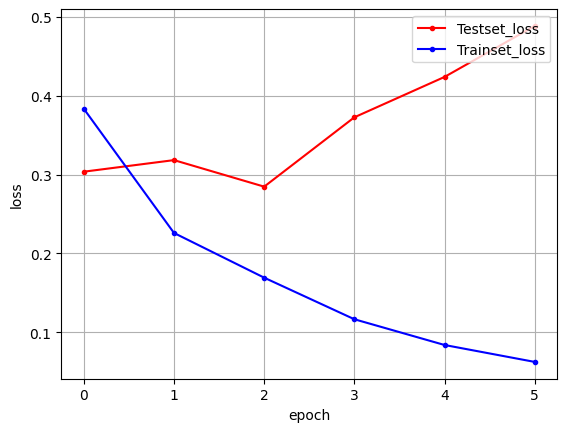

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 데이터셋으로 나눈다. 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞춘다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조 설정
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델 실행
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

# 검증셋과 학습셋의 오차를 저장 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
